In [6]:
# Import libraries
## for profiling
from profiler.main import profile

# for titiler-xarray
from typing import Any
from zarr_reader import xarray_open_dataset, get_variable
import morecantile
from xarray_tile_reader import XarrayTileReader

# for titiler-pgstac
from titiler.pgstac.mosaic import PGSTACBackend
from typing import Any, Dict, List, Tuple
from rio_tiler.mosaic import mosaic_reader
from rio_tiler.models import ImageData
from geojson_pydantic import Polygon

# Only if wanting to see a picture
import io
from PIL import Image

import os
os.environ['AWS_PROFILE'] = 'veda-dev'

In [2]:
search_dict: Dict[str, Any] = {
    'collections': ["CMIP6_ensemble_median_TAS"],
    'datetime': "1951-01-01T00:00:00Z",
    'bbox': [-180, -90, 180, 90]
}

xyz_tile = (0,0,0)

## Profile titiler-xarray

In [ ]:
@profile(add_to_return=True, quiet=False, log_library='s3fs')
def tile(src_path: str, x: int, y: int, z: int, *, variable: str, time_slice: str = None, **kwargs: Any):

    with xarray_open_dataset(
        src_path,
        group=z,
        decode_times=False,
        **kwargs,
    ) as dataset:
        dataarray = get_variable(dataset, variable=variable, time_slice=time_slice)
        
        with XarrayTileReader(dataarray) as src_dst:
            return src_dst.tile(x, y, z)

In [ ]:
image_and_assets, logs = tile(
    "s3://power-analysis-ready-datastore/power_901_monthly_meteorology_utc.zarr", 
    *xyz_tile,
    reference=False,
    variable="TS",
)
# logs

In [ ]:
content = image_and_assets.render(
    img_format='PNG'
)

im = Image.open(io.BytesIO(content))
im

## Profile titiler-pgstac

In [3]:
import pgstac.profile_pgstac as profile_pgstac 

In [4]:
image_and_assets, logs = profile_pgstac.tile(*xyz_tile)
logs

{'pgstac-search': 77.21, 'get_tile': [4.407602071762085], 'mosaic': 4410.85}


{'cprofile': ['   ncalls  tottime  percall  cumtime  percall filename:lineno(function)',
  "       10    4.409    0.441    4.409    0.441 {method 'acquire' of '_thread.lock' objects}",
  '        4    0.092    0.023    0.094    0.023 connection.py:949(wait)',
  '        2    0.001    0.000    0.001    0.000 core.py:3433(__setmask__)']}

/Users/aimeebarciauskas/github/developmentseed/tile-benchmarking/profiling/venv-profiling/lib/python3.9/site-packages/rio_tiler/models.py:648: InvalidDatatypeWarning: Invalid type: `float64` for the `PNG` driver. Data will be rescaled using min/max type bounds or dataset_statistics.
  warnings.warn(


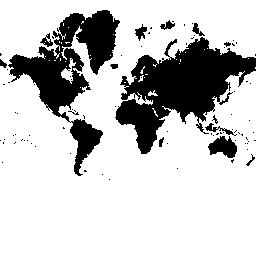

In [5]:
content = image_and_assets[0].render(
    img_format='PNG'
)

im = Image.open(io.BytesIO(content))
im